# RNN

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.


# 시계열 예측하기

In [2]:
# batch_size로 요청한 만큼 n_steps길이의 여러 시계열을 만든다.
# 각 시계열에는 타임스텝마다 하나의 값만 있다. 
# 이 함수는 [배치크기, 타임스텝수, 1] 크기의 넘파이 배열을 반환한다. 즉, 타임스텝 길이의 벡터를 배치크기만큼 만든다.
# 각 시계열은 진폭이 같고 진동 수와 위상이 랜덤한 두 개의 사인 곡선을 더하고 약간의 잡음을 추가한다.

def generate_time_series(batch_size, n_steps):
    # (4, batch_size, 1) 크기의 0~1 사이의 임의의 숫자가 적인 array를 리턴함
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    # np.linspace(구간 시작점, 구간 끝점, 구간 내 숫자 개수)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time-offsets1) * (freq1 * 10 + 10)) # 사인곡선 1
    series += 0.2 * np.sin((time-offsets2) * (freq2 * 20 + 20)) # + 사인곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps)-0.5) # + 잡음
    return series[..., np.newaxis].astype(np.float32)

#### # 시계열의 입력특성은 보통 [배치크기, 타임스텝수, 차원 수] 로 전달된다.

In [3]:
np.random.seed(42)


n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

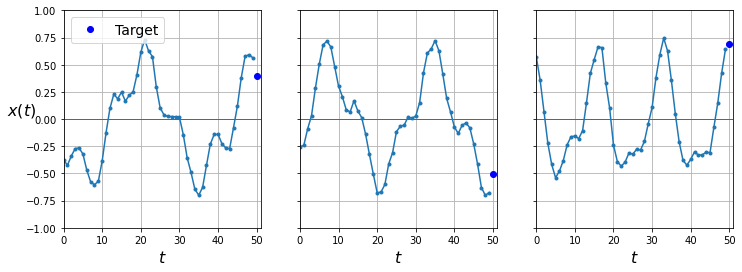

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

# 기준 성능
RNN을 시작하기 전에 기준 성능을 몇개 준비하는 것이 좋다. 그렇지 않은면 실제 시본 모델모다 성능일 나쁠 때도 잘 작동한다고 생각할 수 있다. 

예를 들어 가장 간단한 방법은 각 시계열의 마지막 값을 그대로 예측하는 것이다. 이를 naive forecasting이라고 한다. 

이 방법은 그냥 입력받은 시퀀스의 마지막 값을 예측한 값으로 사용해서 실제값과 비교하는 것이다.

가끔은 이 성능을 뛰어넘는게 굉장히 어렵다. 이 경우 MSE는 0.020 이다.

In [5]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

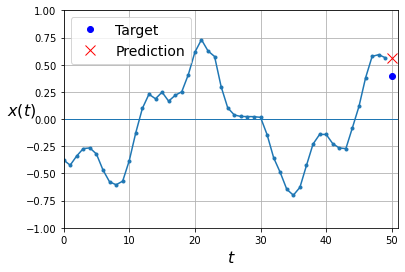

In [6]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

또 간단한 방법은 완전 연결 네트워크를 사용하는 것이다. 이 네트워크는 입력마다 1차원 특성배열을 기대하기 때문에 Flatten 층을 추가해야한다. 

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 927us/step - loss: 0.1167 - val_loss: 0.0347
Epoch 2/20
219/219 [==============================] - 0s 633us/step - loss: 0.0273 - val_loss: 0.0216
Epoch 3/20
219/219 [==============================] - 0s 633us/step - loss: 0.0176 - val_loss: 0.0149
Epoch 4/20
219/219 [==============================] - 0s 619us/step - loss: 0.0128 - val_loss: 0.0117
Epoch 5/20
219/219 [==============================] - 0s 638us/step - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
219/219 [==============================] - 0s 638us/step - loss: 0.0089 - val_loss: 0.0086
Epoch 7/20
219/219 [==============================] - 0s 647us/step - loss: 0.0078 - val_loss: 0.0076
Epoch 8/20
219/219 [==============================] - 0s 633us/step - loss: 0.0070 - val_loss: 0.0067
Epoch 9/20
219/219 [==============================] - 0s 638us/step - loss: 0.0062 - val_loss: 0.0060
Epoch 10/20
219/219 [==============================] - 0s 629us/step - loss: 0.005

In [8]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 452us/step - loss: 0.0037


0.0036672933492809534

<B> 순진한 예측보다 완전 연결 네트워크를 사용한 선형 예측이 좋은 성능을 보였다.

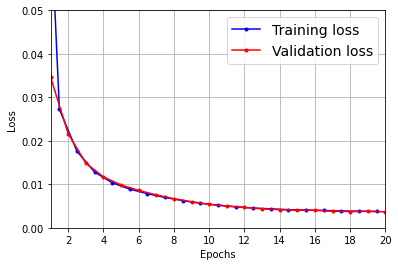

In [9]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 403us/step


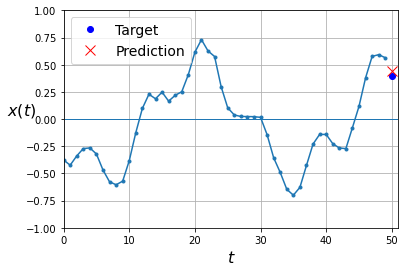

In [10]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# 간단한 RNN 구현하기 | Simple RNN

In [11]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None, 1])
])

위 코드가 가장 간단하게 만들 수 있는 RNN 이다. 
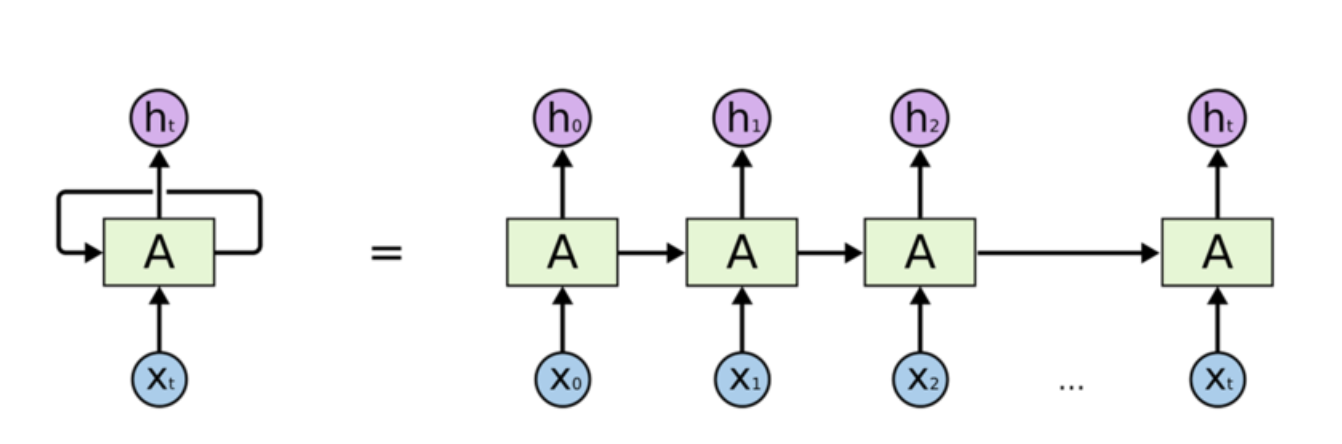
위 그림의 왼쪽 처럼 하나의 뉴런으로 이루어진 하나의 층을 가진다. <br>
순환신경망은 어떤 길이의 타임 스텝도 처리할 수 있기 때문에 입력 시퀀스의 길이를 지정할 필요가 없다. 기본적으로  SimpleRNN층은 tanh를 활성화 함수로 사용한다. 

[이 글](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)에 왜 tanh 함수를 선호하는지 나와있다.

이 모델을 학습 시키면 naive forcasting 보다는 성능이 좋지만, 선형 모델을 앞지르지 못한다. 왜냐하면 파라미터 수 가 너무 많이 차이가 나기 때문이다. 

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None, 1])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.7312 - val_loss: 0.6056
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.4402 - val_loss: 0.3523
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.3291 - val_loss: 0.2990
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2815 - val_loss: 0.2588
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2421 - val_loss: 0.2227
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.2050 - val_loss: 0.1882
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1708 - val_loss: 0.1606
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1485 - val_loss: 0.1459
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1425 - val_loss: 0.1503
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1411 - val_loss: 0.1448

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.1445


0.144504576921463

SimpleRNN에 대해서 알아 보았지만, 이 모델은 파라미터 수가 너무 적어서 좋은 예측을 하기 어렵다. 

이제 Deep RNN 에 대해서 알아보자

# Deep RNN

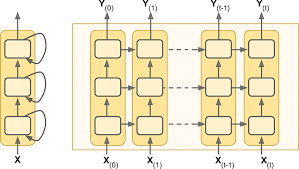

심층 RNN 은 위 그림처럼 셀을 여러 층으로 쌓는 것이 일반적이다. 

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # 모든 순환층에서 return_sequences=True 로 설정해야한다. 
    # 그렇지 않으면 3D배열이 아닌 2D 배열이 출력되고 다음 순환 층이 3D형태로 시퀀스를 받지 못해서 작동하지 못한다.
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0384 - val_loss: 0.0074
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0032 - val_loss: 0.0030

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0027


0.0027203841600567102

In [16]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


드디어 선형모델을 앞질렀다. 

하지만 마지막 층은 이상적이지 않다. 단변량 시계열을 예측하기 때문에 하나의 유닛이 필요하고 이는 타임스텝마다 하나의 출력을 만들어야한다는 뜻이다. 하나의 유닛을 가진다는 것은 은닉 상태가 하나의 숫자라는 뜻이다. 많지는 않지만 쓸모가 있지는 않다. 

암튼, 마지막 층은 Dense 층으로 바꾸는 것이 효율이 더 좋다는 말인 것 같다.

위에 말을 잘 이해하지는 못했지만, 마지막 층도 RNN을 사용하면 매 타임스텝마다 값을 저장하고 그 값을 은닉 상태로 만들기 때문에 차라리 Dense층을 사용해서 한번에 처리하는게 더 나을 것이라는 말인 것 같다. 또한, 활성화 함수를 tanh 이외의 함수로 사용하고 싶다면 마지막 층에 Dense 층을 사용하면 된다는 것 같다,

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # 모든 순환층에서 return_sequences=True 로 설정해야한다. 
    # 그렇지 않으면 3D배열이 아닌 2D 배열이 출력되고 다음 순환 층이 3D형태로 시퀀스를 받지 못해서 작동하지 못한다.
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0219 - val_loss: 0.0045
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0027

In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0025


0.0025257833767682314

In [19]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


위 모델이 더 빠르고 성능도 좋다. 또한 출력층의 활성화 함수를 원하는 함수로 바꿀수 있다.

# 여러 타임스텝 앞을 예측하기

만약 여러 타임스텝앞을 예측하고 싶다면, 미리 만들어진 모델로 값을 예측한 뒤, 마치 예측한 값이 입력된 값인것 처럼 계속 예측할 수 있는 방법이 있다.

In [20]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다


series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 11ms/step


In [21]:
Y_pred.shape

(1, 10, 1)

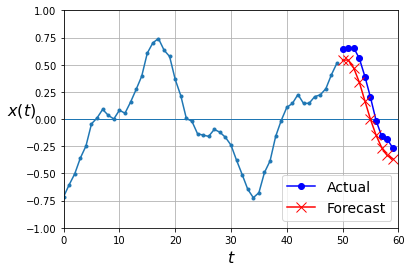

In [22]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [23]:
# 데이터셋 생성후 분류
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [24]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 2ms/step


In [25]:
Y_pred.shape

(2000, 10)

In [26]:
# RNN 모델 MSE
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.02054166

In [27]:
# naive forcasting 모델 MSE

Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [28]:
# 선형 모델 MSE

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 872us/step - loss: 0.1282 - val_loss: 0.0672
Epoch 2/20
219/219 [==============================] - 0s 661us/step - loss: 0.0542 - val_loss: 0.0458
Epoch 3/20
219/219 [==============================] - 0s 659us/step - loss: 0.0409 - val_loss: 0.0373
Epoch 4/20
219/219 [==============================] - 0s 652us/step - loss: 0.0349 - val_loss: 0.0329
Epoch 5/20
219/219 [==============================] - 0s 652us/step - loss: 0.0314 - val_loss: 0.0300
Epoch 6/20
219/219 [==============================] - 0s 656us/step - loss: 0.0290 - val_loss: 0.0281
Epoch 7/20
219/219 [==============================] - 0s 656us/step - loss: 0.0272 - val_loss: 0.0264
Epoch 8/20
219/219 [==============================] - 0s 656us/step - loss: 0.0258 - val_loss: 0.0251
Epoch 9/20
219/219 [==============================] - 0s 656us/step - loss: 0.0247 - val_loss: 0.0241
Epoch 10/20
219/219 [==============================] - 0s 665us/step - loss: 0.023

위 방법은 다음 스텝에 대한 예측은 보통 더 미래의 타임 스텝에 대한 예측보다 정확하다. 미래의 타임 스텝은 오차가 누적될 수 있기 때문이다. 이 성능을 단순한 예측이나 간단한 선형 모델과 비교하는 것이 더 의미가 있다. 단순한 방식 성능이 아주 나쁘다. 선형 모델은 RNN모델 보다 좋은 성능을 낼 수 있다. 

---------
두번째 방법은 RNN을 훈=련하여 다음 값 10 개를 한번에 예측하는 것이다. sequence-to-vector 모델을 사용하지만 1개가 아니라 값 10개를 출력한다. 먼저 타깃을 다음 10개의 값이 담긴 벡터로 바꾸어야한다.

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0683 - val_loss: 0.0305
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0256 - val_loss: 0.0198
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0187 - val_loss: 0.0152
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0138 - val_loss: 0.0117
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0125
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0101

In [30]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 119ms/step


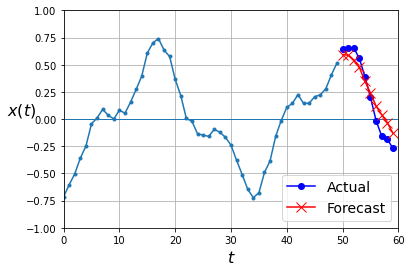

In [31]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

위 모델은 잘 작동한다. 하지만 더 개선할 여지가 있다. 마지막 타임스텝에서만 다음 10개값을 예측하는 대신 모둔 터암 수탭애소 더움 겂 10개를 예축하도록 모델을 훈련할 수 있다. 다르게 말하면 이 sequence to vector RNN을 sequence to sequence RNN으로 바꾸는 것이다. 이 방식의 장점은 마지막 타임 스텝 에서의 출력 뿐만 아니라 모든 타임 스텝에서 RNN  출력에 대한 항이 손실에 포함된다는 것이다. 이는 더 많은 학습이 된다는 것이다. 각 타임스텝의 출력에서 그레이언트가 흐를 수 있다. 

In [33]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [34]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))